# Loan Prediction Based on Customer Behavior

# 라이브러리 호출

In [137]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from imblearn.over_sampling import SMOTE

import eli5
from eli5.sklearn import PermutationImportance

# 데이터 불러오기

In [190]:
train = pd.read_csv('https://raw.githubusercontent.com/2hg7274/CodeStates/main/Section2%20Project/Data/Training%20Data.csv')

In [191]:
print('train 데이터 형태: ', train.shape)
print('test 데이터 형태: ', test.shape)

train 데이터 형태:  (252000, 13)
test 데이터 형태:  (28000, 12)


In [192]:
train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [193]:
test.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [194]:
# train데이터와 test데이터의 ID 컬럼 동일시 하기 위해 컬럼명 변경
train.rename(columns={'Id':'ID'}, inplace=True)

# Data Proprocessing

## 중복 ID 검사

In [195]:
def analysis_on_features(df):
    '''
    데이터 프레임에 중복된 Id가 있는지 파악
    '''
    duplicated_rows = 0
    dupli = df.duplicated(subset=['ID'])
    for i in dupli.index:
        if dupli[i] == True:
            duplicated_rows += 1
            print(i)
    
    return duplicated_rows

In [196]:
train_duplicated_rows = analysis_on_features(train)

print('train 데이터의 중복열 개수는 {}개 이다.' .format(train_duplicated_rows))

train 데이터의 중복열 개수는 0개 이다.


## Feature Engineering 및 Preprocessing

## PCA
상관관계가 높았던'Experience'와 'CURRENT_JOB_YRS'에 대해 주성분 분석

In [197]:
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(train[['Experience', 'CURRENT_JOB_YRS']])

In [198]:
pca.explained_variance_ratio_
# 1차원으로 축소를 하여도 설명력이 86.7%이다. 
# 따라서 1차원으로 차원 축소 진행

array([0.86780334, 0.13219666])

In [199]:
# 전처리 함수
def eda_preprocess(df):
    # 분석에 사용하지 않을 'ID' 컬럼 삭제
    df = df.drop(['ID'], axis=1)

    # 'CITY'컬럼 삭제 -> 너무 높은 카디널리티
    df = df.drop(['CITY'], axis=1)

    # 'OutofWork_time' -> 직장이 없던 기간
    df['OutofWork_time'] = df['Experience'] - df['CURRENT_JOB_YRS']

    # PCA로 새로운 컬럼 생성 후, 'Experience', 'CURRENT_JOB_YRS'컬럼 삭제 -> PCA로 차원 축소를 진행
    standard_scle = StandardScaler()
    df[['Experience', 'CURRENT_JOB_YRS']] = standard_scle.fit_transform(df[['Experience', 'CURRENT_JOB_YRS']])
    pca = PCA(n_components=1)
    printcipalComponents = pca.fit_transform(df[['Experience', 'CURRENT_JOB_YRS']])
    PCAdf = pd.DataFrame(data=printcipalComponents, columns = ['PC1'])
    df = pd.concat([df, PCAdf], axis=1)    

    df = df.drop(['Experience'], axis=1)
    df = df.drop(['CURRENT_JOB_YRS'], axis=1)

    return df



In [200]:
train_processed = eda_preprocess(train.copy())

In [201]:
train_processed

,Income,Age,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_HOUSE_YRS,Risk_Flag,OutofWork_time,PC1
0,1303834,23,single,rented,no,Mechanical_engineer,Madhya_Pradesh,13,0,0,-1.480938
1,7574516,40,single,rented,no,Software_Developer,Maharashtra,13,0,1,0.506974
2,3991815,66,married,rented,no,Technical_writer,Kerala,10,0,0,-1.169253
3,6256451,41,single,rented,yes,Software_Developer,Odisha,12,1,0,-1.792624
4,5768871,47,single,rented,no,Civil_servant,Tamil_Nadu,14,1,8,-0.538534
...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,single,rented,no,Surgeon,West_Bengal,11,0,7,0.278721
251996,2843572,26,single,rented,no,Army_officer,Madhya_Pradesh,11,0,4,-0.074680
251997,4522448,46,single,rented,no,Design_Engineer,Maharashtra,12,0,0,-0.234197
251998,6507128,45,single,rented,no,Graphic_Designer,Puducherry,10,0,0,-2.415994


# Modeling - Risk_Flag 예측

## 변수 및 모델 정의

In [202]:
# train, vl 데이터 나누는 함수
def split(df, target):
    X = df.drop([target], axis=1)
    y = df[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [203]:
train1 = train_processed.copy()

In [204]:
# train / test 데이터 나누기
X_train, X_test, y_train, y_test = split(train1, 'Risk_Flag')

In [207]:
# train / val 데이터 나누기
train1 = pd.concat([X_train, y_train], axis=1)
X_train, X_val, y_train, y_val = split(train1, 'Risk_Flag')

In [209]:
print('X_train의 형태: ', X_train.shape)
print('X_val의 형태: ', X_val.shape)
print('X_test의 형태: ', X_test.shape)

X_train의 형태:  (161280, 10)
X_val의 형태:  (40320, 10)
X_test의 형태:  (50400, 10)


#### 기준 모델

In [154]:
# 기준 모델
# 평가지표는 accuracy, f1 score
acc_f1_score = {}

baseline_predict = [train1['Risk_Flag'].mode()[0]]*len(X_val)

baseline_acc = accuracy_score(y_val, baseline_predict)
baseline_f1 = f1_score(y_val, baseline_predict)

acc_f1_score['baseline'] = [baseline_acc, baseline_f1]


#### LogisticRegression

In [155]:
# LogisticRegression
pipe_LogisticR = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('logistic', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42))
])

dists_LR = {
    'logistic__C': [1.0, 2.0, 3.0],
    'logistic__solver': ['lbfgs', 'liblinear', 'saga']
}

clf_LR = RandomizedSearchCV(
    pipe_LogisticR,
    param_distributions=dists_LR,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_LR.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_LR.best_params_, '\n')
print('Accuracy ', clf_LR.best_score_)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

최적 하퍼라미터:  {'logistic__solver': 'saga', 'logistic__C': 1.0} 

Accuracy  0.726686507936508


In [156]:
pipe_LogisticR = clf_LR.best_estimator_
LR_pred = pipe_LogisticR.predict(X_val)

LR_acc = accuracy_score(y_val, LR_pred)
LR_f1 = f1_score(y_val, LR_pred)

acc_f1_score['LogisticRegression'] = [LR_acc, LR_f1]

#### RandomForestClassifier

In [157]:
# RandomForestClassifier
pipe_RFC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('RFclassifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True, random_state=42))
])

dists_RFC = {
    'RFclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'RFclassifier__max_depth': [10, 15, 20],
    'RFclassifier__min_samples_split': [2, 3, 4],
    'RFclassifier__min_samples_leaf': [1, 2, 3],
    'RFclassifier__max_features': ['sqrt', 'log2']
}

clf_RFC = RandomizedSearchCV(
    pipe_RFC,
    param_distributions=dists_RFC,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_RFC.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_RFC.best_params_, '\n')
print('Accuracy ', clf_RFC.best_score_)


최적 하퍼라미터:  {'RFclassifier__min_samples_split': 4, 'RFclassifier__min_samples_leaf': 1, 'RFclassifier__max_features': 'log2', 'RFclassifier__max_depth': 20, 'RFclassifier__criterion': 'entropy'} 

Accuracy  0.8960168650793652


In [158]:
pipe_RFC = clf_RFC.best_estimator_
RFC_pred = pipe_RFC.predict(X_val)

RFC_acc = accuracy_score(y_val, RFC_pred)
RFC_f1 = f1_score(y_val, RFC_pred)

acc_f1_score['RandomForestClassifier'] = [RFC_acc, RFC_f1]

#### XGBoostClassifier

In [159]:
class XGBoostWithEarlyStopClassifier(BaseEstimator):
    def __init__(self, early_stopping_rounds=7, test_size=0.2, 
                 eval_metric='error', scale_pos_weight=7, n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='error' 
        self.scale_pos_weight = scale_pos_weight
        self.n_jobs = n_jobs       
        self.random_state = random_state
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStopClassifier):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [160]:
# XGBClassifier
pipe_XGBC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('XGBC', XGBoostClassifierWithEarlyStop())
])

dists_XGBc = {
    'XGBC__max_depth': [10, 15, 20],
    'XGBC__max_leaves': [1, 2, 3,],
    'XGBC__learning_rate': [0.1, 0.2]
}

clf_XGBc= RandomizedSearchCV(
    pipe_XGBC,
    param_distributions=dists_XGBc,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_XGBc.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_XGBc.best_params_, '\n')
print('Accuracy: ', clf_XGBc.best_score_)


[0]	validation_0-error:0.12075
[1]	validation_0-error:0.11973
[2]	validation_0-error:0.12060
[3]	validation_0-error:0.12050
[4]	validation_0-error:0.12047
[5]	validation_0-error:0.11995
[6]	validation_0-error:0.11995
[7]	validation_0-error:0.12060
[8]	validation_0-error:0.12081
[9]	validation_0-error:0.12156
[10]	validation_0-error:0.12181
[11]	validation_0-error:0.12150
[12]	validation_0-error:0.12187
[13]	validation_0-error:0.12174
[14]	validation_0-error:0.12196
[15]	validation_0-error:0.12181
[16]	validation_0-error:0.12215
[17]	validation_0-error:0.12215
[18]	validation_0-error:0.12218
[19]	validation_0-error:0.12246
[20]	validation_0-error:0.12209
[21]	validation_0-error:0.12199
[22]	validation_0-error:0.12212
[23]	validation_0-error:0.12187
[24]	validation_0-error:0.12190
[25]	validation_0-error:0.12184
[26]	validation_0-error:0.12193
[27]	validation_0-error:0.12212
[28]	validation_0-error:0.12218
[29]	validation_0-error:0.12202
[30]	validation_0-error:0.12178
[31]	validation_0-

In [161]:
pipe_XGBC = clf_XGBc.best_estimator_
pipe_XGBC.fit(X_train, y_train)
XGBC_pred = pipe_XGBC.predict(X_val)

XGBC_acc = accuracy_score(y_val, XGBC_pred),
XGBC_f1 = f1_score(y_val, XGBC_pred)

acc_f1_score['XGBClassifier'] = [XGBC_acc, XGBC_f1]

[0]	validation_0-error:0.10868
[1]	validation_0-error:0.10632
[2]	validation_0-error:0.10419
[3]	validation_0-error:0.10355
[4]	validation_0-error:0.10360
[5]	validation_0-error:0.10392
[6]	validation_0-error:0.10332
[7]	validation_0-error:0.10367
[8]	validation_0-error:0.10360
[9]	validation_0-error:0.10345
[10]	validation_0-error:0.10278
[11]	validation_0-error:0.10221
[12]	validation_0-error:0.10211
[13]	validation_0-error:0.10198
[14]	validation_0-error:0.10198
[15]	validation_0-error:0.10184
[16]	validation_0-error:0.10174
[17]	validation_0-error:0.10144
[18]	validation_0-error:0.10156
[19]	validation_0-error:0.10146
[20]	validation_0-error:0.10131
[21]	validation_0-error:0.10112
[22]	validation_0-error:0.10069
[23]	validation_0-error:0.10055
[24]	validation_0-error:0.10050
[25]	validation_0-error:0.10067
[26]	validation_0-error:0.10064
[27]	validation_0-error:0.10050
[28]	validation_0-error:0.10062
[29]	validation_0-error:0.10042
[30]	validation_0-error:0.10055
[31]	validation_0-

#### AdaBoostClassifier

In [162]:
# AdaBoostClassifier
pipe_Ada = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('ada', AdaBoostClassifier(random_state=42))
])

dists_ada = {
    'ada__n_estimators': [50, 100, 150],
    'ada__learning_rate': [1.0, 2.0],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

clf_ada = RandomizedSearchCV(
    pipe_Ada,
    param_distributions=dists_ada,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_ada.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_ada.best_params_, '\n')
print('Accuracy: ', clf_ada.best_score_)

최적 하퍼라미터:  {'ada__n_estimators': 150, 'ada__learning_rate': 1.0, 'ada__algorithm': 'SAMME.R'} 

Accuracy:  0.8774305555555557


In [163]:
pipe_Ada = clf_ada.best_estimator_
pipe_Ada.fit(X_train, y_train)
Ada_pred = pipe_Ada.predict(X_val)

Ada_acc = accuracy_score(y_val, Ada_pred),
Ada_f1 = f1_score(y_val, Ada_pred)

acc_f1_score['AdaBoostClassifier'] = [Ada_acc, Ada_f1]

#### GradientBoostClassifier

In [164]:
# GradientBoostClassifier
pipe_GBC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

dists_gbc = {
    'gbc__learning_rate': [0.1, 0.2, 0.3],
    'gbc__n_estimators': [100, 120],
    'gbc__min_samples_split': [2, 3, 4],
    'gbc__min_samples_leaf': [1, 2, 3],
    'gbc__max_depth': [3, 4, 5]
}

clf_gbc = RandomizedSearchCV(
    pipe_GBC,
    param_distributions=dists_gbc,
    n_iter=4,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_gbc.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_gbc.best_params_, '\n')
print('Accuracy: ', clf_gbc.best_score_)

최적 하퍼라미터:  {'gbc__n_estimators': 100, 'gbc__min_samples_split': 3, 'gbc__min_samples_leaf': 3, 'gbc__max_depth': 5, 'gbc__learning_rate': 0.3} 

Accuracy:  0.8833184523809525


In [165]:
pipe_GBC = clf_gbc.best_estimator_
pipe_GBC.fit(X_train, y_train)
Gbc_pred = pipe_GBC.predict(X_val)

Gbc_acc = accuracy_score(y_val, Gbc_pred),
Gbc_f1 = f1_score(y_val, Gbc_pred)

acc_f1_score['GradientBoostClassifier'] = [Gbc_acc, Gbc_f1]

In [166]:
# 모델들의 accuracy와 f1 비교 
acc_f1_score

{'baseline': [0.8759325396825397, 0.0],
 'LogisticRegression': [0.8759325396825397, 0.0],
 'RandomForestClassifier': [0.8944444444444445, 0.6431924882629108],
 'XGBClassifier': [(0.8980357142857143,), 0.5520787936895319],
 'AdaBoostClassifier': [(0.876031746031746,), 0.003508771929824561],
 'GradientBoostClassifier': [(0.8822222222222222,), 0.18929254302103252]}

## 모델 선택
정확도 점수로 모델을 선택 한다면 XGBClassifier가 선택되어야 한다.  
하지만 f1점수를 보면 RandomForestClassifier가 더 높은 것을 알 수 있고, 정확도 또한 XGBClassifier와 차이가 심하지 않다.  
따라서 ***RnadomForestClassifier모델***을 선택한다.  

### 가장 좋은 모델의 성능 확인

In [169]:
blm_pred = pipe_RFC.predict(X_test)

blm_acc = accuracy_score(y_test, blm_pred)
blm_f1 = f1_score(y_test, blm_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc}, F-1 Score: {blm_f1}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.8130714285714286, F-1 Score: 0.1006872852233677


In [170]:
print(classification_report(y_test, blm_pred, target_names=['class 0', 'class 1']))


              precision    recall  f1-score   support

     class 0       0.87      0.92      0.90     24407
     class 1       0.13      0.08      0.10      3593

    accuracy                           0.81     28000
   macro avg       0.50      0.50      0.50     28000
weighted avg       0.78      0.81      0.79     28000



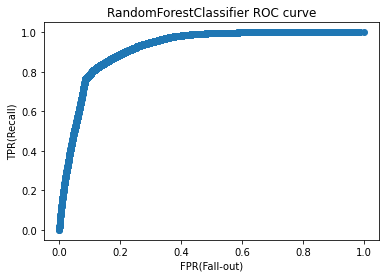

In [171]:
y_pred_proba_randomforest = pipe_RFC.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_randomforest)
roc = pd.DataFrame({
    'FPR(Fall-out)':fpr,
    'TPRate(Recall)':tpr,
    'Threshold':thresholds
})

plt.scatter(fpr, tpr)
plt.title('RandomForestClassifier ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

In [172]:
# 최적의 threshold 찾기
optimal_idx_randomforest = np.argmax(tpr-fpr)
optimal_threshold_randomforest = thresholds[optimal_idx_randomforest]
print('idx: ', optimal_idx_randomforest, ', threshold: ', optimal_threshold_randomforest, '\n')

y_pred_optimal_randomforest = y_pred_proba_randomforest >= optimal_threshold_randomforest
print('최적의 threshold를 임계값으로 할 때')
print(classification_report(y_val, y_pred_optimal_randomforest), '\n')


y_pred_05 = y_pred_proba_randomforest >= 0.5
print('0.5 임계값으로 할 때')
print(classification_report(y_val, y_pred_05), '\n')

auc_score = roc_auc_score(y_val, y_pred_proba_randomforest)
print('RandomForestClassifier AUC Score: ',auc_score)

idx:  1806 , threshold:  0.36561588764044595 

최적의 threshold를 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     44147
           1       0.49      0.82      0.61      6253

    accuracy                           0.87     50400
   macro avg       0.73      0.85      0.77     50400
weighted avg       0.91      0.87      0.88     50400
 

0.5 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     44147
           1       0.55      0.77      0.64      6253

    accuracy                           0.89     50400
   macro avg       0.76      0.84      0.79     50400
weighted avg       0.91      0.89      0.90     50400
 

RandomForestClassifier AUC Score:  0.9203028234716075


In [173]:
test_pred_proba_RFC = pipe_RFC.predict_proba(X_test)[:,1]

# 최적의 threshold를 기준으로 1과 0 분류
test_pred = []
for i in test_pred_proba_RFC:
    if i >= optimal_threshold_randomforest:
        a = 1
        test_pred.append(a)
    else:
        b = 0
        test_pred.append(b)

blm_acc2 = accuracy_score(y_test, test_pred)
blm_f12 = f1_score(y_test, test_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc2}, F-1 Score: {blm_f12}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.72225, F-1 Score: 0.1486590038314176


In [174]:
print(classification_report(y_test, test_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.87      0.80      0.83     24407
     class 1       0.12      0.19      0.15      3593

    accuracy                           0.72     28000
   macro avg       0.50      0.49      0.49     28000
weighted avg       0.77      0.72      0.75     28000



# Over Sampling - SMOTE
현재 정확도가 높은 RandomForestCalssifier 모델의 F-1 score를 확인해 보면 0.15정도로 낮은 것을 알 수 있다.  
이는 클래스 불균형 때문에 나타는 현상이다.  
따라서 클래스 불균형을 해소하기 위해 오버샘플링의 기법 중 하나인 SMOTE기법을 이용하려고 한다.  

In [175]:
train1

,Income,Age,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_HOUSE_YRS,Risk_Flag,OutofWork_time,PC1
0,1303834,23,single,rented,no,Mechanical_engineer,Madhya_Pradesh,13,0,0,-1.480938
1,7574516,40,single,rented,no,Software_Developer,Maharashtra,13,0,1,0.506974
2,3991815,66,married,rented,no,Technical_writer,Kerala,10,0,0,-1.169253
3,6256451,41,single,rented,yes,Software_Developer,Odisha,12,1,0,-1.792624
4,5768871,47,single,rented,no,Civil_servant,Tamil_Nadu,14,1,8,-0.538534
...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,single,rented,no,Surgeon,West_Bengal,11,0,7,0.278721
251996,2843572,26,single,rented,no,Army_officer,Madhya_Pradesh,11,0,4,-0.074680
251997,4522448,46,single,rented,no,Design_Engineer,Maharashtra,12,0,0,-0.234197
251998,6507128,45,single,rented,no,Graphic_Designer,Puducherry,10,0,0,-2.415994


In [176]:
# 오버샘플링을 하기전에는 문자를 숫자로 바꿔주는 작업이 필요하다. 
train2 = train1.copy()

features = ['Married/Single','Car_Ownership','House_Ownership']
onehot_encoder = OneHotEncoder(use_cat_names=True, cols=features)
train2 = onehot_encoder.fit_transform(train2)


features2 = ['Profession','STATE']
ordinal_encoder = OrdinalEncoder(cols=features2)
train2 = ordinal_encoder.fit_transform(train2)

In [177]:
X = train2.drop(['Risk_Flag'],axis=1)
y = train2.Risk_Flag
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [178]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [179]:
# 성능이 가장 좋았던 3개의 모델에 대해서만 다시 학습 진행

#### XGBClassifier - SMOTE

In [183]:
class XGBoostWithEarlyStopClassifier(BaseEstimator):
    def __init__(self, early_stopping_rounds=5, test_size=0.2, 
                 eval_metric='error', scale_pos_weight=5, n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='error' 
        self.scale_pos_weight = scale_pos_weight
        self.n_jobs = n_jobs       
        self.random_state = random_state
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStopClassifier):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [184]:
acc_f1_score2 = {}

In [185]:
# XGBClassifier
pipe_XGBC = Pipeline([
    ('XGBC', XGBoostClassifierWithEarlyStop())
])

dists_XGBc = {
    'XGBC__max_depth': [10, 15, 20],
    'XGBC__max_leaves': [1, 2, 3,],
    'XGBC__learning_rate': [0.1, 0.2]
}

clf_XGBc= RandomizedSearchCV(
    pipe_XGBC,
    param_distributions=dists_XGBc,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_XGBc.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_XGBc.best_params_, '\n')
print('Accuracy: ', clf_XGBc.best_score_)


[0]	validation_0-error:0.32142
[1]	validation_0-error:0.29754
[2]	validation_0-error:0.28976
[3]	validation_0-error:0.28543
[4]	validation_0-error:0.27730
[5]	validation_0-error:0.27084
[6]	validation_0-error:0.26386
[7]	validation_0-error:0.26147
[8]	validation_0-error:0.25340
[9]	validation_0-error:0.25069
[10]	validation_0-error:0.24334
[11]	validation_0-error:0.24306
[12]	validation_0-error:0.24264
[13]	validation_0-error:0.23647
[14]	validation_0-error:0.22419
[15]	validation_0-error:0.22369
[16]	validation_0-error:0.21975
[17]	validation_0-error:0.21299
[18]	validation_0-error:0.21277
[19]	validation_0-error:0.21076
[20]	validation_0-error:0.20329
[21]	validation_0-error:0.19928
[22]	validation_0-error:0.19678
[23]	validation_0-error:0.19072
[24]	validation_0-error:0.18968
[25]	validation_0-error:0.18899
[26]	validation_0-error:0.18692
[27]	validation_0-error:0.18487
[28]	validation_0-error:0.18203
[29]	validation_0-error:0.17940
[30]	validation_0-error:0.17858
[31]	validation_0-

In [186]:
pipe_XGBC = clf_XGBc.best_estimator_
XGBC_pred = pipe_XGBC.predict(X_val)

XGBC_acc = accuracy_score(y_val, XGBC_pred),
XGBC_f1 = f1_score(y_val, XGBC_pred)

acc_f1_score2['XGBClassifier'] = [XGBC_acc, XGBC_f1]

#### RandomForestClassifier - SMOTE

In [187]:
# RandomForestClassifier
pipe_RFC = Pipeline([
    ('RFclassifier', RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42))
])

dists_RFC = {
    'RFclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'RFclassifier__max_depth': [10, 15, 20],
    'RFclassifier__min_samples_split': [2, 3, 4],
    'RFclassifier__min_samples_leaf': [1, 2, 3],
    'RFclassifier__max_features': ['sqrt', 'log2']
}

clf_RFC = RandomizedSearchCV(
    pipe_RFC,
    param_distributions=dists_RFC,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_RFC.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_RFC.best_params_, '\n')
print('Accuracy ', clf_RFC.best_score_)


최적 하퍼라미터:  {'RFclassifier__min_samples_split': 3, 'RFclassifier__min_samples_leaf': 1, 'RFclassifier__max_features': 'log2', 'RFclassifier__max_depth': 20, 'RFclassifier__criterion': 'entropy'} 

Accuracy  0.9163618430675259


In [188]:
pipe_RFC = clf_RFC.best_estimator_
RFC_pred = pipe_RFC.predict(X_val)

RFC_acc = accuracy_score(y_val, RFC_pred)
RFC_f1 = f1_score(y_val, RFC_pred)

acc_f1_score2['RandomForestClassifier'] = [RFC_acc, RFC_f1]

#### GradientBoostClassifier - SMOTE

In [189]:
# GradientBoostClassifier
pipe_GBC = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state=42))
])

dists_gbc = {
    'gbc__learning_rate': [0.1, 0.2],
    'gbc__n_estimators': [100, 120],
    'gbc__min_samples_split': [2, 3, 4],
    'gbc__min_samples_leaf': [1, 2, 3],
    'gbc__max_depth': [3, 4, 5]
}

clf_gbc = RandomizedSearchCV(
    pipe_GBC,
    param_distributions=dists_gbc,
    n_iter=4,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_gbc.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_gbc.best_params_, '\n')
print('Accuracy: ', clf_gbc.best_score_)

KeyboardInterrupt: 

In [ ]:
pipe_GBC = clf_gbc.best_estimator_
Gbc_pred = pipe_GBC.predict(X_val)

Gbc_acc = accuracy_score(y_val, Gbc_pred),
Gbc_f1 = f1_score(y_val, Gbc_pred)

acc_f1_score2['GradientBoostClassifier'] = [Gbc_acc, Gbc_f1]

In [ ]:
acc_f1_score2

## 모델 선택 - SMOTE
정확도와 F-1 socre에서 모두 좋은 성능을 보인  
XGBClassifier모델을 선택한다. 

### 가장 좋은 모델의 성능 확인 - SMOTE

In [ ]:
X_test = onehot_encoder.transform(X_test)
X_test = ordinal_encoder.transform(X_test)


In [ ]:
blm_pred = pipe_RFC.predict(X_test)

blm_acc = accuracy_score(y_test, blm_pred)
blm_f1 = f1_score(y_test, blm_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc}, F-1 Score: {blm_f1}')

In [ ]:
print(classification_report(y_test, blm_pred, target_names=['class 0', 'class 1']))

# 모델 해석


## Permutation Importance

In [ ]:
permuter = PermutationImportance(
    pipe_RFC.named_steps['RFclassifier'],
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
X_val_transformed = pipe_RFC.named_steps['onehot'].transform(X_val)
X_val_transformed = pipe_RFC.named_steps['ordinal'].transform(X_val_transformed)
permuter.fit(X_val_transformed, y_val)

In [ ]:
feature_names = X_val_transformed.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)